In [1]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
sys.path.append("/pymorph")
from scipy.signal import find_peaks


from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline
#plt.style.use(['dark_background'])

## Post Processing Model Runs

In [63]:
def calculate_wave_height( z):
    top_peaks, _ = find_peaks(z, height = z.mean()*1.1)
    bottom_peaks, _ = find_peaks(-1.*z, height = z.mean()*-0.8, distance = int(1.2/dx))

    ztop = [z[i] for i in top_peaks]
    zbottom = [z[i] for i in bottom_peaks]

    ztop = np.array(ztop)
    ztop = np.delete(ztop, ztop.argmin())
    
    zbottom = np.array(zbottom)
    zbottom = np.delete(zbottom, zbottom.argmax())
    

    return ztop.mean() - zbottom.mean()
                
            
    
def calculate_wave_length(z,dx):
    peaks, _ = find_peaks(-1.*z, height = z.mean()*-1., distance = int(1.2/dx))
    lengths = []
    last_peak = None
    for peak in peaks:
        if last_peak == None:
            last_peak = peak
        else:
            
            tmpLength = dx * (peak-last_peak)
            
            if tmpLength > 1.2:
                lengths.append(tmpLength)
                last_peak = peak
                
    lengths = np.array(lengths)
    #lengths = np.delete(lengths, lengths.argmin())
    return lengths
    
def calculate_wave_movement(last_peak_index, current_z):
    
    peaks, _ = find_peaks(-1.*current_z, height = current_z.mean()*-0.8, distance = int(1.2/dx))
    
    updated_peak = None
    for peak in peaks:
        if peak > last_peak_index:
            updated_peak = peak
            #print(peak, last_peak_index)
            break

    return updated_peak

def calculate_wave_speed(verts, dx, dt):
    last_peak_index = None
    velocities = []
    timesteps = []
    base_index = 2
    step_index = 4
    for t in range(0, (verts.shape[0]), step_index):
        current_z = verts[t,:,1]
        peaks, _  = find_peaks(-1.*current_z, height = -1*current_z.mean(), distance=100)
        if last_peak_index is not None:
            delta = calculate_wave_movement(last_peak_index, current_z)
            last_peak_index = peaks[base_index]
            velocities.append(delta*dx/(dt*step_index))
            timesteps.append( dt * t )
        last_peak_index = peaks[base_index]
    return velocities, timesteps

def plot_results(verts):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))

    heights = [calculate_wave_height(verts[t,:,1]) for t in range((verts.shape[0]))]
    times = [t*5. for t in range((verts.shape[0]))]

    ax1.plot(times, heights)
    ax1.set_xlabel('Time (mins)')
    ax1.set_ylabel('$\Delta$ (m)')

    dx = x[1] - x [0]
    lengths = [calculate_wave_length(verts[t,:,1],dx).mean() for t in range((verts.shape[0]))]
    ax2.plot(times, lengths)
    ax2.set_xlabel('Time (mins)')
    ax2.set_ylabel('$\Lambda$ (m)')
    ax2.set_ylim([0, 3.0])

    for t in range(0, (verts.shape[0]),15):
        z = verts[t,:,1]
        h = verts[t,:,4]
        x = verts[t,:,0]
        timestep = t * 5.
        ax3.plot(x,z, label='{0} mins'.format(timestep))
        ax3.plot(x,z+h, 'b')

    ax3.legend()
    ax3.set_xlabel('x (m)')
    ax3.set_ylabel('z (m)')


    v, timesteps = calculate_wave_speed(verts, dx, 5)
    ax4.plot(timesteps,v)
    ax4.set_ylim([0, 0.5])

    ax4.set_xlabel('Time (mins)')
    ax4.set_ylabel('Dune migration rate (m/min)')

    f.subplots_adjust(hspace=0.3)
    
def make_animation(verts):
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure(figsize=(12, 3))
    ax = plt.axes(xlim=(0, 8), ylim=(0, 0.1))

    x0 = verts[0,:,0]
    z0 = verts[0,:,1]

    plt.plot(x0,z0)
    line, = ax.plot([], [], lw=2)



    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return line,

    # animation function.  This is called sequentially
    def animate(i):
        x = verts[i,:,0]
        y = verts[i,:,1]
        line.set_data(x, y)
        return line,
    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=58, interval=80, blit=True)
    return anim

### 32 Centimetre Case

In [25]:
verts32_10mm = np.load(os.path.join('_output','dune_5_q_32m_h_357mm_D50_1mm_verts.npy'))

verts32_08mm = np.load(os.path.join('_output','dune_5_q_32m_h_357mm_D50_0.8mm_verts.npy'))

verts32_12mm = np.load(os.path.join('_output','dune_5_q_32m_h_357mm_D50_1.2mm_verts.npy'))

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


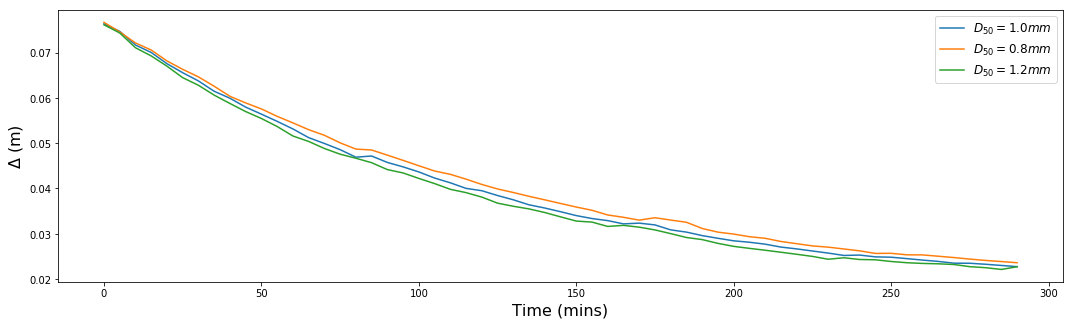

In [87]:
plt.figure(figsize=(18,5))

heights32_10mm = [calculate_wave_height(verts32_10mm[t,:,1]) for t in range((verts32_10mm.shape[0]))]
heights32_08mm = [calculate_wave_height(verts32_08mm[t,:,1]) for t in range((verts32_08mm.shape[0]))]
heights32_12mm = [calculate_wave_height(verts32_12mm[t,:,1]) for t in range((verts32_12mm.shape[0]))]

times = [t*5. for t in range((verts32_10mm.shape[0]))]

plt.plot(times, heights32_10mm, label='$D_{50} = 1.0mm $')
plt.plot(times, heights32_08mm, label='$D_{50} = 0.8mm $')
plt.plot(times, heights32_12mm, label='$D_{50} = 1.2mm $')

font = {'family' : 'Times New Roman',
        'weight' : 'light',
        'size'   : 16}

plt.xlabel('Time (mins)', **font)
plt.ylabel('$\Delta$ (m)', **font)

plt.legend(loc='upper right',fontsize=12)

(1, 1.5)

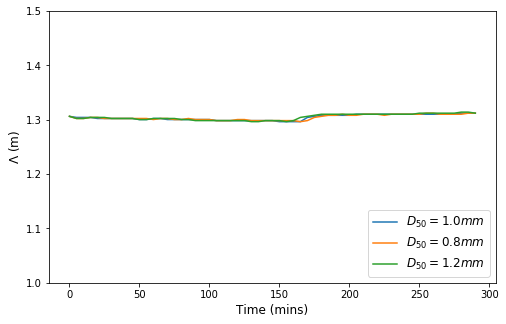

In [55]:
plt.figure(figsize=(8,5))

dx = x[1] - x [0]
lengths32_10mm = [calculate_wave_length(verts32_10mm[t,:,1],dx).mean() for t in range((verts32_10mm.shape[0]))]
lengths32_08mm = [calculate_wave_length(verts32_08mm[t,:,1],dx).mean() for t in range((verts32_08mm.shape[0]))]
lengths32_12mm = [calculate_wave_length(verts32_12mm[t,:,1],dx).mean() for t in range((verts32_12mm.shape[0]))]

plt.plot(times, lengths32_10mm, label='$D_{50} = 1.0mm $')
plt.plot(times, lengths32_08mm, label='$D_{50} = 0.8mm $')
plt.plot(times, lengths32_12mm, label='$D_{50} = 1.2mm $')

plt.legend(loc='lower right',fontsize=12)

plt.xlabel('Time (mins)',**font)
plt.ylabel('$\Lambda$ (m)',**font)
plt.ylim([1, 1.5])


(0, 0.25)

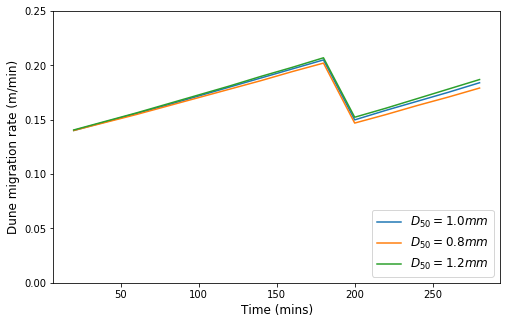

In [57]:
plt.figure(figsize=(8,5))

velocities32_10mm, timesteps = calculate_wave_speed(verts32_10mm, dx, 5)
velocities32_08mm, timesteps = calculate_wave_speed(verts32_08mm, dx, 5)
velocities32_12mm, timesteps = calculate_wave_speed(verts32_12mm, dx, 5)

plt.plot(timesteps, velocities32_10mm, label='$D_{50} = 1.0mm $')
plt.plot(timesteps, velocities32_08mm, label='$D_{50} = 0.8mm $')
plt.plot(timesteps, velocities32_12mm, label='$D_{50} = 1.2mm $')

plt.legend(loc='lower right',fontsize=12)

plt.xlabel('Time (mins)',**font)
plt.ylabel('Dune migration rate (m/min)',**font)
plt.ylim([0, 0.25])


Text(0, 0.5, 'z (m)')

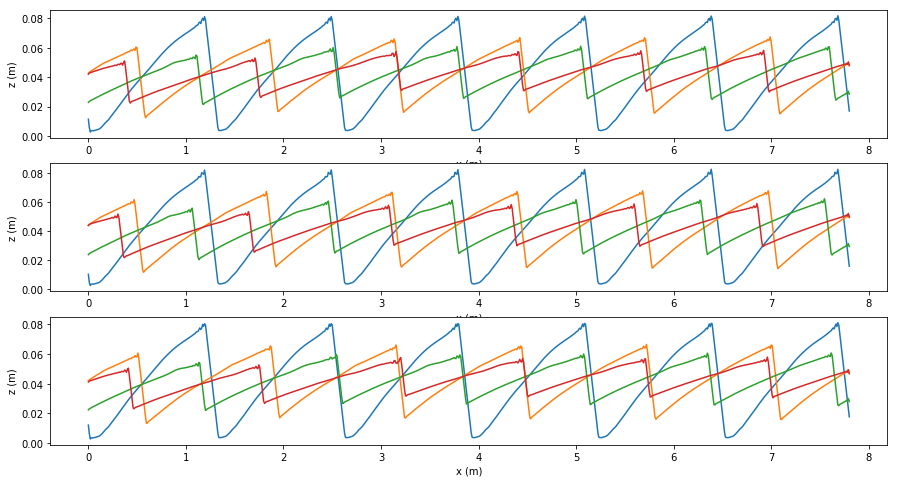

In [61]:
f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(15,8))

for t in range(0, (verts32_10mm.shape[0]),15):
        z = verts32_10mm[t,:,1]
        h = verts32_10mm[t,:,4]
        x = verts32_10mm[t,:,0]
        timestep = t * 5.
        ax1.plot(x,z, label='{0} mins'.format(timestep))
        #ax1.plot(x,z+h, 'b')


ax1.set_xlabel('x (m)')
ax1.set_ylabel('z (m)')

for t in range(0, (verts32_08mm.shape[0]),15):
        z = verts32_08mm[t,:,1]
        h = verts32_08mm[t,:,4]
        x = verts32_08mm[t,:,0]
        timestep = t * 5.
        ax2.plot(x,z, label='{0} mins'.format(timestep))
        #ax2.plot(x,z+h, 'b')


ax2.set_xlabel('x (m)')
ax2.set_ylabel('z (m)')

for t in range(0, (verts32_12mm.shape[0]),15):
        z = verts32_12mm[t,:,1]
        h = verts32_12mm[t,:,4]
        x = verts32_12mm[t,:,0]
        timestep = t * 5.
        ax3.plot(x,z, label='{0} mins'.format(timestep))
        #ax3.plot(x,z+h, 'b')


ax3.set_xlabel('x (m)')
ax3.set_ylabel('z (m)')

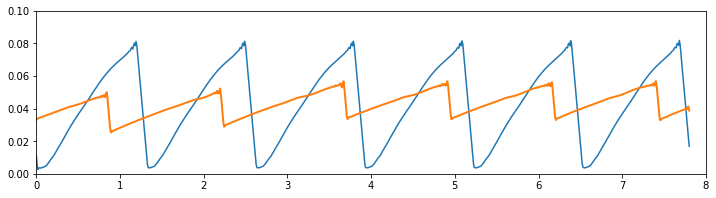

In [64]:
anim = make_animation(verts32_10mm)
HTML(anim.to_html5_video())

## 20 cm cases

In [65]:
verts20_10mm = np.load(os.path.join('_output','dune_5_q_32m_h_357mm_D50_1mm_verts.npy'))

verts20_08mm = np.load(os.path.join('_output','dune_5_q_20cm_h_237mm_D50_0.8mm_verts.npy'))

verts20_12mm = np.load(os.path.join('_output','dune_5_q_20cm_h_237mm_D50_1mm_verts.npy'))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


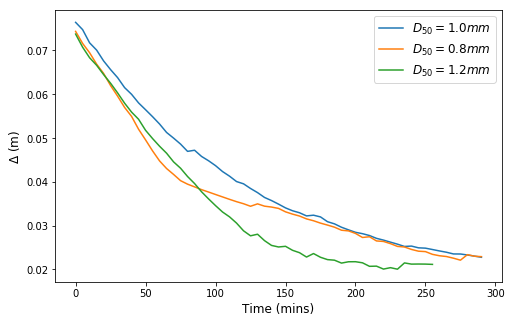

In [66]:
plt.figure(figsize=(8,5))

heights_10mm = [calculate_wave_height(verts20_10mm[t,:,1]) for t in range((verts20_10mm.shape[0]))]
heights_08mm = [calculate_wave_height(verts20_08mm[t,:,1]) for t in range((verts20_08mm.shape[0]))]
heights_12mm = [calculate_wave_height(verts20_12mm[t,:,1]) for t in range((verts20_12mm.shape[0]))]

times = [t*5. for t in range((verts32_10mm.shape[0]))]

plt.plot(times, heights_10mm, label='$D_{50} = 1.0mm $')
plt.plot(times, heights_08mm, label='$D_{50} = 0.8mm $')
plt.plot(times, heights_12mm, label='$D_{50} = 1.2mm $')

font = {'family' : 'Times New Roman',
        'weight' : 'light',
        'size'   : 12}

plt.xlabel('Time (mins)', **font)
plt.ylabel('$\Delta$ (m)', **font)

plt.legend(loc='upper right',fontsize=12)

(1, 3.5)

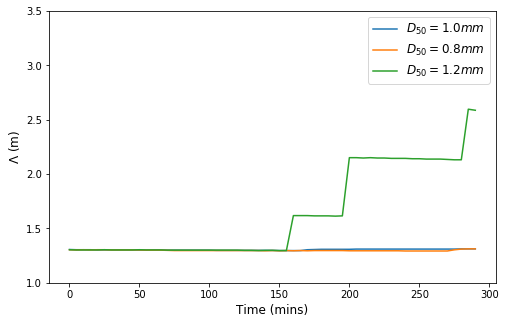

In [70]:
plt.figure(figsize=(8,5))

dx = x[1] - x [0]
lengths_10mm = [calculate_wave_length(verts20_10mm[t,:,1],dx).mean() for t in range((verts20_10mm.shape[0]))]
lengths_08mm = [calculate_wave_length(verts20_08mm[t,:,1],dx).mean() for t in range((verts20_08mm.shape[0]))]
lengths_12mm = [calculate_wave_length(verts20_12mm[t,:,1],dx).mean() for t in range((verts20_12mm.shape[0]))]

plt.plot(times, lengths_10mm, label='$D_{50} = 1.0mm $')
plt.plot(times, lengths_08mm, label='$D_{50} = 0.8mm $')
plt.plot(times, lengths_12mm, label='$D_{50} = 1.2mm $')

plt.legend(loc='upper right',fontsize=12)

plt.xlabel('Time (mins)',**font)
plt.ylabel('$\Lambda$ (m)',**font)
plt.ylim([1, 3.5])

(0, 0.5)

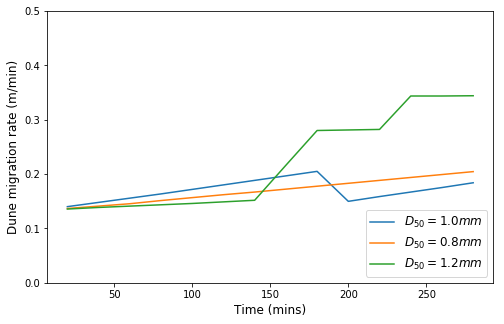

In [72]:
plt.figure(figsize=(8,5))

velocities_10mm, timesteps = calculate_wave_speed(verts20_10mm, dx, 5)
velocities_08mm, timesteps = calculate_wave_speed(verts20_08mm, dx, 5)
velocities_12mm, timesteps = calculate_wave_speed(verts20_12mm, dx, 5)

plt.plot(timesteps, velocities_10mm, label='$D_{50} = 1.0mm $')
plt.plot(timesteps, velocities_08mm, label='$D_{50} = 0.8mm $')
plt.plot(timesteps, velocities_12mm, label='$D_{50} = 1.2mm $')

plt.legend(loc='lower right',fontsize=12)

plt.xlabel('Time (mins)',**font)
plt.ylabel('Dune migration rate (m/min)',**font)
plt.ylim([0, 0.5])

Text(0, 0.5, 'z (m)')

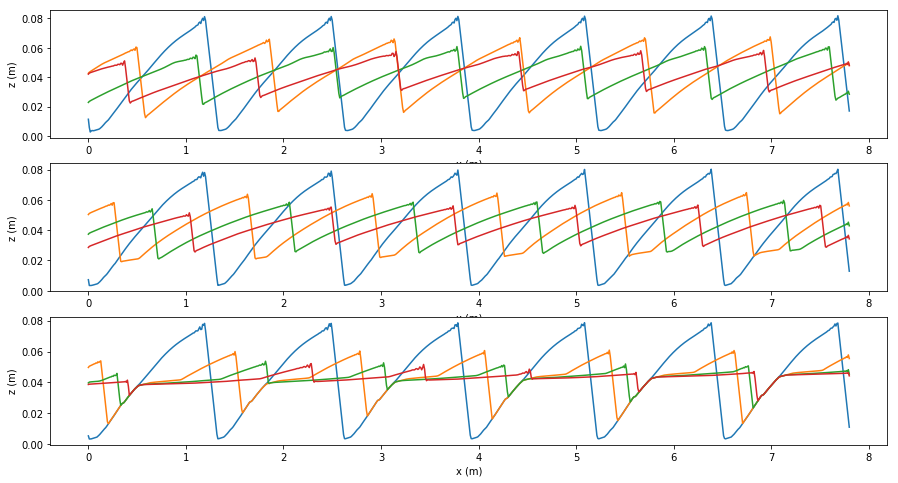

In [73]:
f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(15,8))

for t in range(0, (verts20_10mm.shape[0]),15):
        z = verts20_10mm[t,:,1]
        h = verts20_10mm[t,:,4]
        x = verts20_10mm[t,:,0]
        timestep = t * 5.
        ax1.plot(x,z, label='{0} mins'.format(timestep))
        #ax1.plot(x,z+h, 'b')


ax1.set_xlabel('x (m)')
ax1.set_ylabel('z (m)')

for t in range(0, (verts20_08mm.shape[0]),15):
        z = verts20_08mm[t,:,1]
        h = verts20_08mm[t,:,4]
        x = verts20_08mm[t,:,0]
        timestep = t * 5.
        ax2.plot(x,z, label='{0} mins'.format(timestep))
        #ax2.plot(x,z+h, 'b')


ax2.set_xlabel('x (m)')
ax2.set_ylabel('z (m)')

for t in range(0, (verts20_12mm.shape[0]),15):
        z = verts20_12mm[t,:,1]
        h = verts20_12mm[t,:,4]
        x = verts20_12mm[t,:,0]
        timestep = t * 5.
        ax3.plot(x,z, label='{0} mins'.format(timestep))
        #ax3.plot(x,z+h, 'b')


ax3.set_xlabel('x (m)')
ax3.set_ylabel('z (m)')

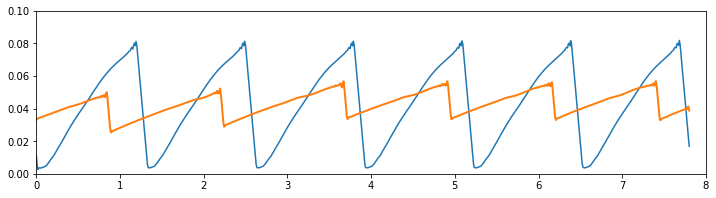

In [77]:
anim = make_animation(verts20_10mm)
HTML(anim.to_html5_video())

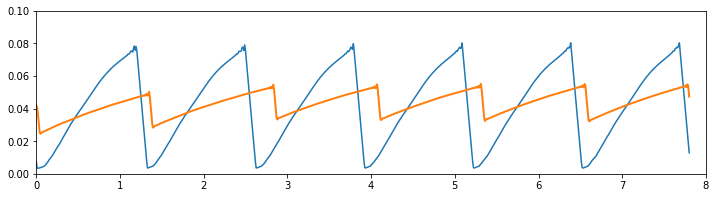

In [78]:
anim = make_animation(verts20_08mm)
HTML(anim.to_html5_video())

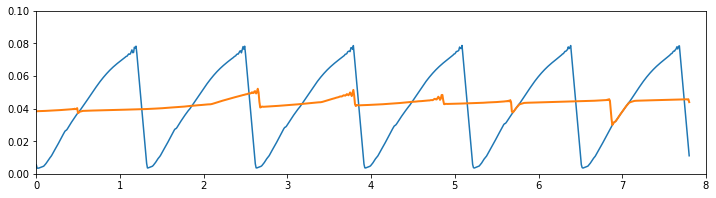

In [79]:
anim = make_animation(verts20_12mm)
HTML(anim.to_html5_video())

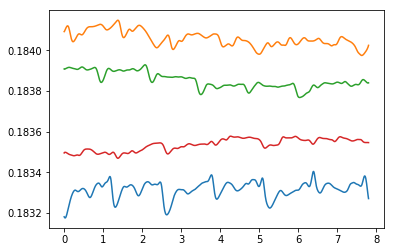

In [85]:
for t in range(0, (verts20_10mm.shape[0]),15):
        u = verts20_10mm[t,:,3]
        x = verts20_10mm[t,:,0]
        timestep = t * 5.
        plt.plot(x,u, label='{0} mins'.format(timestep))